<a href="https://colab.research.google.com/github/aainabatool/ComputerVision/blob/main/CV_A3_Segmentation_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install albumentations==1.3.0 opencv-python matplotlib tqdm
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 kB 6.5 MB/s eta 0:00:00
  Attempting uninstall: albumentations
    Found existing installation: albumentations 2.0.8
    Uninstalling albumentations-2.0.8:
      Successfully uninstalled albumentations-2.0.8
Device: cuda


In [11]:
# Download Oxford-IIIT Pet Dataset
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

!tar -xf images.tar.gz
!tar -xf annotations.tar.gz


--2025-12-05 18:18:02--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/pets/images.tar.gz [following]
--2025-12-05 18:18:03--  https://thor.robots.ox.ac.uk/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/octet-stream]
Saving to: ‘images.tar.gz’

images.tar.gz       100%[===================>] 755.23M  27.7MB/s    in 28s     

2025-12-05 18:18:31 (27.3 MB/s) - ‘images.tar.gz’ saved [791918971/791918971]

--2025-12-05 18:18:31--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
Resolving www.r

1 → pet → 1
2 → background → 0
3 → border → 0


In [13]:
class OxfordPetsSeg(Dataset):
    def __init__(self, img_dir="images", mask_dir="annotations/trimaps", img_size=256, augment=True):
        self.img_paths = [os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.endswith(".jpg")]
        self.mask_dir = mask_dir
        self.img_size = img_size
        self.augment = augment

        self.transform = A.Compose([
            A.Resize(img_size, img_size),
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.3),
        ])

        self.to_tensor = A.Compose([
            A.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
            ToTensorV2()
        ])

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        mask_path = os.path.join(self.mask_dir, os.path.basename(img_path).replace(".jpg", ".png"))

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, 0)  # grayscale
        mask = cv2.resize(mask, (self.img_size, self.img_size), interpolation=cv2.INTER_NEAREST)

        # convert trimap to binary mask
        mask = np.where(mask == 1, 1, 0).astype(np.float32)

        # apply augmentations
        if self.augment:
            augmented = self.transform(image=img, mask=mask)
            img, mask = augmented["image"], augmented["mask"]

        img = self.to_tensor(image=img)["image"]
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

        return img, mask


In [14]:
dataset = OxfordPetsSeg(img_size=256, augment=True)

# Split 80/20
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=2)


In [15]:
import torch.nn as nn

class DoubleConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(True),
            nn.Conv2d(out_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(True)
        )

    def forward(self, x): return self.conv(x)

class UNetSmall(nn.Module):
    def __init__(self, base=16):
        super().__init__()
        self.inc = DoubleConv(3, base)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(base, base*2))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(base*2, base*4))
        self.bottom = nn.Sequential(nn.MaxPool2d(2), DoubleConv(base*4, base*8))

        self.up2 = nn.ConvTranspose2d(base*8, base*4, 2, stride=2)
        self.conv2 = DoubleConv(base*8, base*4)

        self.up1 = nn.ConvTranspose2d(base*4, base*2, 2, stride=2)
        self.conv1 = DoubleConv(base*4, base*2)

        self.up0 = nn.ConvTranspose2d(base*2, base, 2, stride=2)
        self.conv0 = DoubleConv(base*2, base)

        self.outc = nn.Conv2d(base, 1, 1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        xb = self.bottom(x3)

        x = self.up2(xb)
        x = self.conv2(torch.cat([x, x3], dim=1))

        x = self.up1(x)
        x = self.conv1(torch.cat([x, x2], dim=1))

        x = self.up0(x)
        x = self.conv0(torch.cat([x, x1], dim=1))

        return torch.sigmoid(self.outc(x))


In [16]:
def dice_loss(pred, target, eps=1e-7):
    pred = pred.contiguous()
    target = target.contiguous()
    inter = (pred * target).sum(dim=(2,3))
    union = pred.sum(dim=(2,3)) + target.sum(dim=(2,3))
    dice = (2*inter + eps) / (union + eps)
    return 1 - dice.mean()


In [19]:
def train_seg(model, train_loader, val_loader, epochs=8, lr=1e-3):
    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    bce = nn.BCELoss()

    history = {"train_loss": [], "val_loss": [], "iou": [], "dice": [], "pixel_acc": []}

    for ep in range(epochs):
        model.train()
        train_loss = 0
        for img, mask in tqdm(train_loader):
            img, mask = img.to(device), mask.to(device)
            pred = model(img)
            loss = 0.5 * bce(pred, mask) + 0.5 * dice_loss(pred, mask)

            opt.zero_grad()
            loss.backward()
            opt.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        iou_scores, dice_scores, acc_scores = [], [], []
        with torch.no_grad():
            for img, mask in val_loader:
                img, mask = img.to(device), mask.to(device)
                pred = model(img)
                val_loss += 0.5 * bce(pred, mask) + 0.5 * dice_loss(pred, mask)

                pred_bin = (pred > 0.5).float()
                inter = (pred_bin * mask).sum(dim=(1,2,3))
                union = pred_bin.sum(dim=(1,2,3)) + mask.sum(dim=(1,2,3)) - inter
                iou_scores.append((inter / (union + 1e-7)).mean().item())

                dice_scores.append(((2*inter)/(pred_bin.sum(dim=(1,2,3)) + mask.sum(dim=(1,2,3)) + 1e-7)).mean().item())
                acc_scores.append((pred_bin.eq(mask).float().mean(dim=(1,2,3))).mean().item())

        val_loss /= len(val_loader)
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["iou"].append(np.mean(iou_scores))
        history["dice"].append(np.mean(dice_scores))
        history["pixel_acc"].append(np.mean(acc_scores))

        print(f"Epoch {ep+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | IoU: {np.mean(iou_scores):.4f} | Dice: {np.mean(dice_scores):.4f} | Pixel Acc: {np.mean(acc_scores):.4f}")

    return model, history


In [20]:
model = UNetSmall(base=16)
model, history = train_seg(model, train_loader, val_loader, epochs=8, lr=1e-3)
torch.save(model.state_dict(), "unet_oxford.pth")


100%|██████████| 739/739 [01:00<00:00, 12.16it/s]


Epoch 1/8 | Train Loss: 0.4640 | Val Loss: 0.3741 | IoU: 0.5693 | Dice: 0.7055 | Pixel Acc: 0.8260


100%|██████████| 739/739 [00:59<00:00, 12.40it/s]


Epoch 2/8 | Train Loss: 0.3532 | Val Loss: 0.3397 | IoU: 0.6209 | Dice: 0.7494 | Pixel Acc: 0.8476


100%|██████████| 739/739 [00:59<00:00, 12.52it/s]


Epoch 3/8 | Train Loss: 0.3047 | Val Loss: 0.2950 | IoU: 0.6618 | Dice: 0.7813 | Pixel Acc: 0.8717


100%|██████████| 739/739 [00:59<00:00, 12.49it/s]


Epoch 4/8 | Train Loss: 0.2796 | Val Loss: 0.2560 | IoU: 0.6903 | Dice: 0.8024 | Pixel Acc: 0.8956


100%|██████████| 739/739 [00:59<00:00, 12.45it/s]


Epoch 5/8 | Train Loss: 0.2620 | Val Loss: 0.2956 | IoU: 0.6428 | Dice: 0.7651 | Pixel Acc: 0.8795


100%|██████████| 739/739 [00:59<00:00, 12.48it/s]


Epoch 6/8 | Train Loss: 0.2493 | Val Loss: 0.2193 | IoU: 0.7302 | Dice: 0.8329 | Pixel Acc: 0.9098


100%|██████████| 739/739 [00:58<00:00, 12.60it/s]


Epoch 7/8 | Train Loss: 0.2391 | Val Loss: 0.2265 | IoU: 0.7174 | Dice: 0.8239 | Pixel Acc: 0.9100


100%|██████████| 739/739 [00:58<00:00, 12.57it/s]


Epoch 8/8 | Train Loss: 0.2316 | Val Loss: 0.2144 | IoU: 0.7338 | Dice: 0.8343 | Pixel Acc: 0.9125


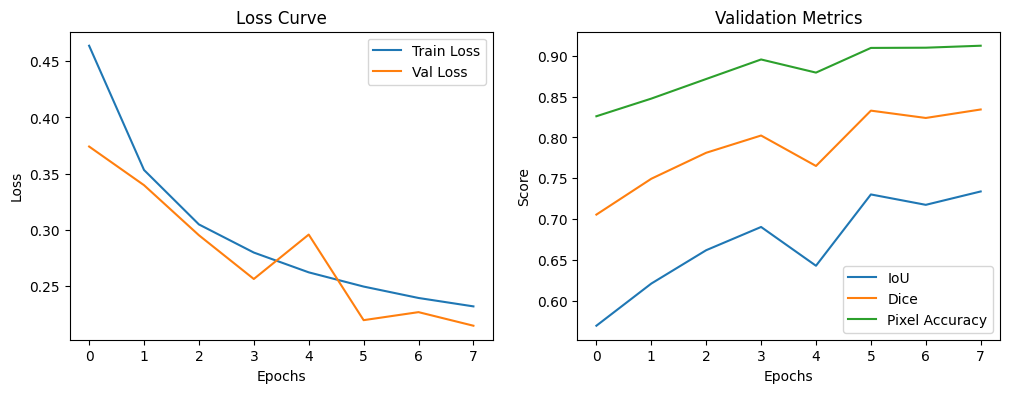

In [22]:
import matplotlib.pyplot as plt

# Convert tensors to CPU / numpy
train_loss = [x.item() if torch.is_tensor(x) else x for x in history["train_loss"]]
val_loss   = [x.item() if torch.is_tensor(x) else x for x in history["val_loss"]]
iou        = [x.item() if torch.is_tensor(x) else x for x in history["iou"]]
dice       = [x.item() if torch.is_tensor(x) else x for x in history["dice"]]
pixel_acc  = [x.item() if torch.is_tensor(x) else x for x in history["pixel_acc"]]

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Val Loss")
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(iou, label="IoU")
plt.plot(dice, label="Dice")
plt.plot(pixel_acc, label="Pixel Accuracy")
plt.title("Validation Metrics")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.legend()

plt.show()


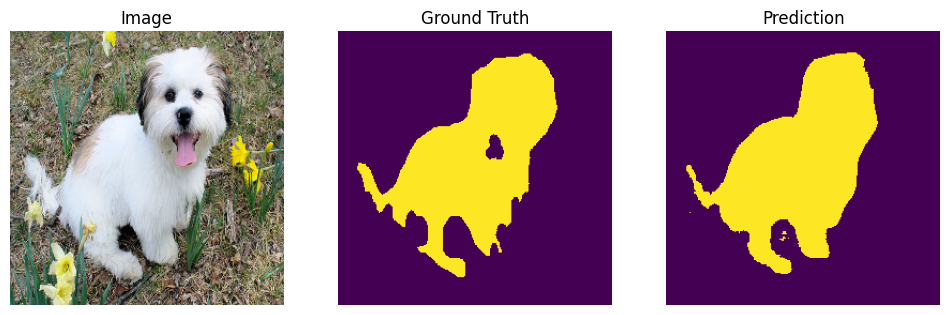

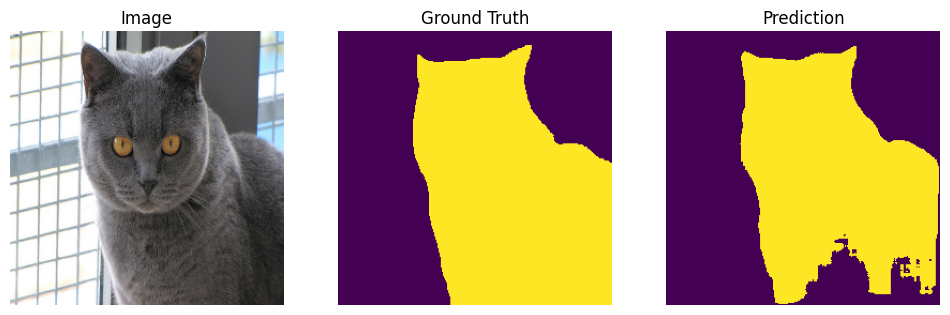

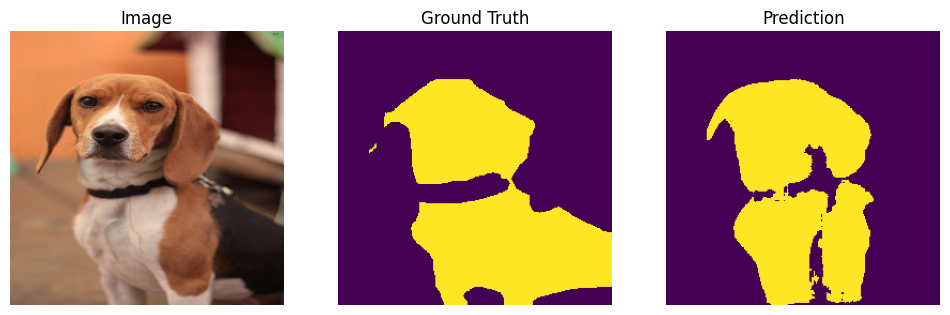

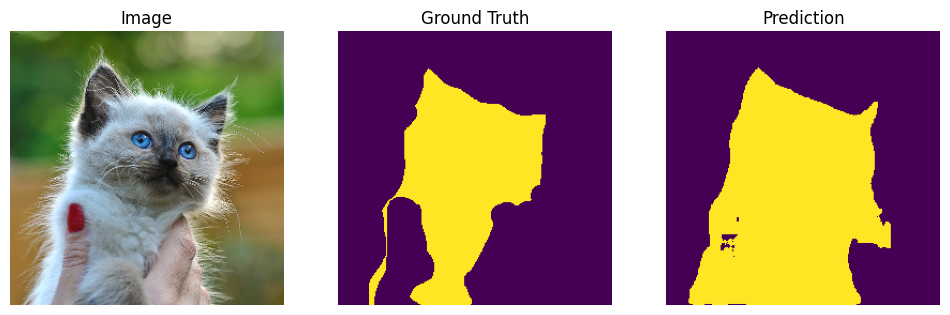

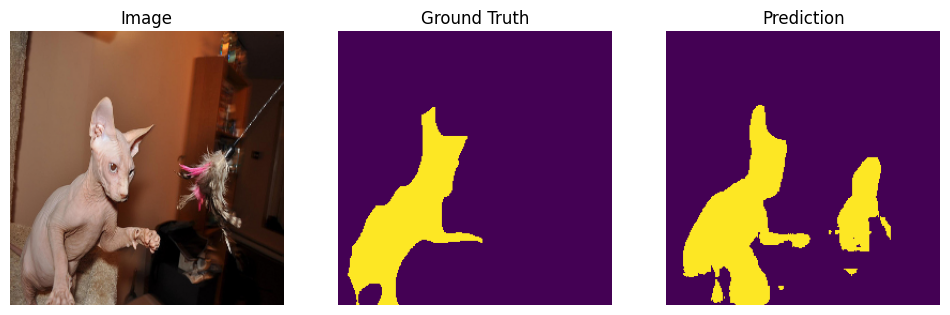

In [23]:
def show_predictions(model, dataset, n=5):
    import random
    model.eval()
    for _ in range(n):
        idx = random.randint(0, len(dataset)-1)
        img, mask = dataset[idx]
        with torch.no_grad():
            pred = model(img.unsqueeze(0).to(device))[0,0].cpu().numpy()
        img_np = img.permute(1,2,0).cpu().numpy() * 0.5 + 0.5  # de-normalize
        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1); plt.imshow(img_np); plt.title("Image"); plt.axis("off")
        plt.subplot(1,3,2); plt.imshow(mask[0].cpu().numpy()); plt.title("Ground Truth"); plt.axis("off")
        plt.subplot(1,3,3); plt.imshow((pred>0.5).astype(int)); plt.title("Prediction"); plt.axis("off")
        plt.show()

show_predictions(model, val_ds, n=5)


In [24]:
# Model size
import os
size_mb = os.path.getsize("unet_oxford.pth") / 1e6
print(f"Model size: {size_mb:.2f} MB")

# FPS (frames per second)
import time
model.eval()
dummy_input = torch.randn(1,3,256,256).to(device)
N = 100
start = time.time()
with torch.no_grad():
    for _ in range(N):
        _ = model(dummy_input)
fps = N / (time.time() - start)
print(f"Inference FPS: {fps:.2f}")


Model size: 1.98 MB
Inference FPS: 254.21


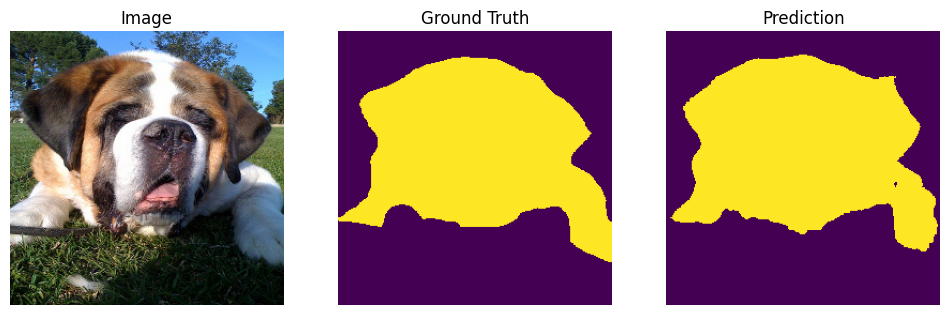

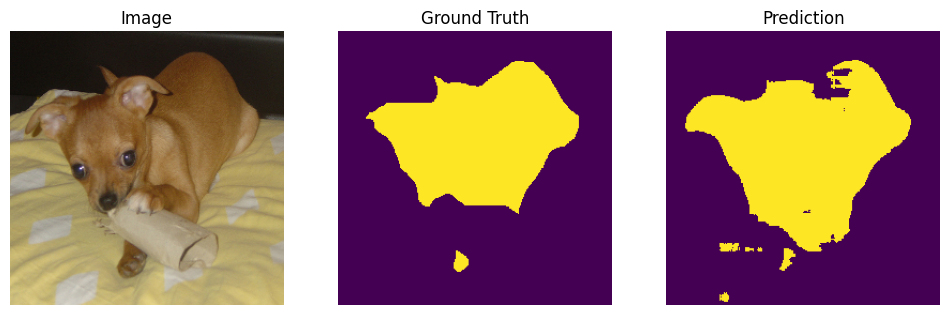

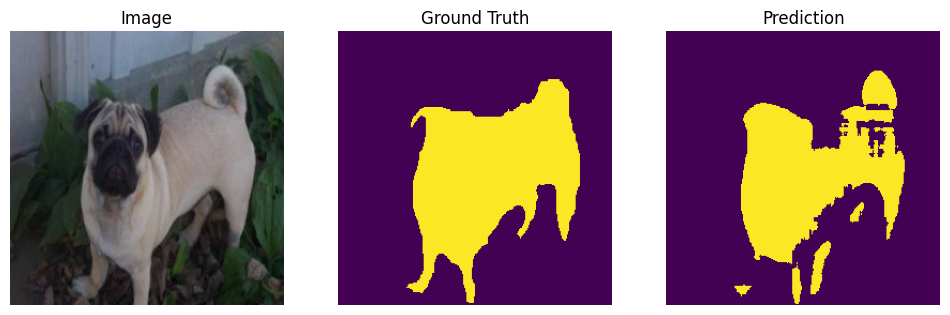

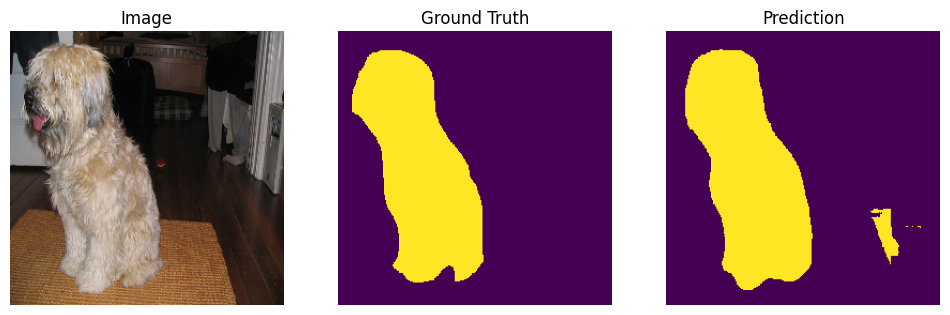

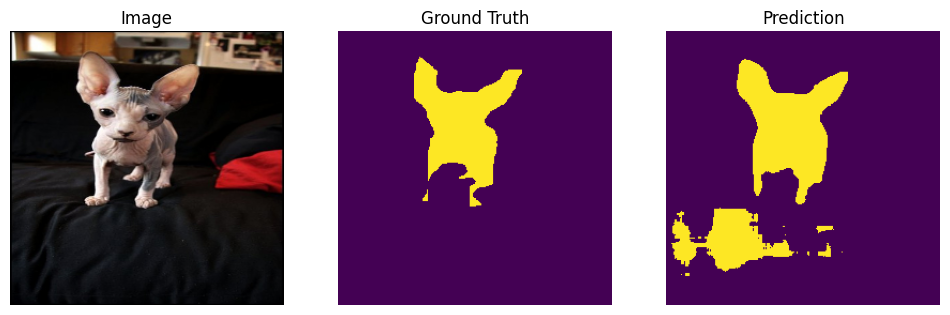

In [25]:
show_predictions(model, val_ds, n=5)  # Shows 5 examples of Image / GT / Prediction


In [26]:
plt.savefig("sample_prediction_1.png")


<Figure size 640x480 with 0 Axes>